In [1]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os
device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU
print("Device available: ", device)

Device available:  cuda


In [2]:
image_path=[]
labels=[]

for i in os.listdir('./db'):
  for label in os.listdir(f'./db/{i}'):
    labels.append(i)
    image_path.append(f'./db/{i}/{label}')

df = pd.DataFrame(zip(image_path, labels), columns=['image_path', 'labels'])
# rows = df[df['labels']=='defective']
# print(rows)
df.head()


,image_path,labels
0,./db/defective/Defective (1).jpg,defective
1,./db/defective/Defective (10).jpg,defective
2,./db/defective/Defective (100).jpg,defective
3,./db/defective/Defective (1000).jpg,defective
4,./db/defective/Defective (1001).jpg,defective


In [3]:
os.getcwd()

'd:\\files\\projects\\tyre-classification'

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(df['image_path'], df['labels'], test_size=0.3, random_state=42, stratify=df['labels'])
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training data size:", len(X_train))
print("Test data size:", len(X_test))
print("Validation data size:", len(X_val))


Training data size: 1299
Test data size: 278
Validation data size: 279


In [5]:
#Preprocessing. Normalising the size of all images

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

label_encoder = LabelEncoder()
label_encoder.fit(df['labels'])
df['labels'] = label_encoder.transform(df['labels'])

In [6]:
class CustomImageDataset:
    def __init__(self, image_paths, label_strs, transform=None, target_transform=None):
      self.image_paths = image_paths
      self.labels = [0 if lab=="good" else 1 for lab in label_strs]
      self.transform = transform
      self.target_transform = target_transform
    def __len__(self):
      # print(len(self.image_paths))
      return len(self.image_paths)
    def __getitem__(self, idx):
      if idx >= len(self):
            raise IndexError
      image_path = self.image_paths[idx]
      image = Image.open(image_path)
      label = self.labels[idx]
      if self.transform:
        image = self.transform(image)
      if self.target_transform:
        label = self.target_transform(label)
      label = torch.tensor(self.labels[idx], dtype=torch.float)
      return image, label

In [7]:
train_dataset=CustomImageDataset(X_train.to_numpy(), y_train.to_numpy(), transform=transform)
test_dataset=CustomImageDataset(X_test.to_numpy(), y_test.to_numpy(), transform=transform)
val_dataset=CustomImageDataset(X_val.to_numpy(), y_val.to_numpy(), transform=transform)

Length of dataset: 1856


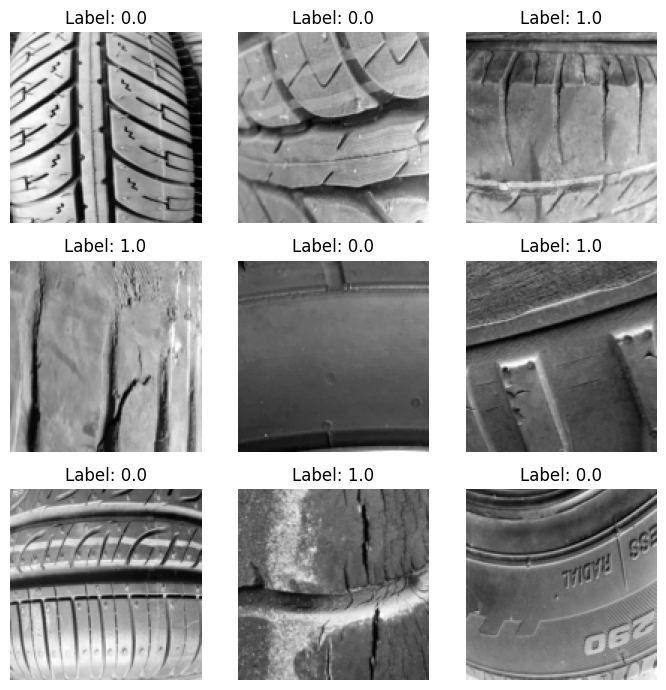

In [8]:
dataset = CustomImageDataset(pd.Series(image_path), pd.Series(labels), transform=transform)
print(f"Length of dataset: {len(dataset)}")
# print(next(iter(dataset)))
loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)

fig, axarr = plt.subplots(3, 3, figsize=(7,7))
for ax in axarr.flatten():

    idx = np.random.randint(0, len(dataset))

    img_tensor, lbl = dataset[idx]

    gray = img_tensor.squeeze(0).numpy()

    ax.imshow(gray, cmap='gray')
    ax.set_title(f"Label: {lbl}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)

In [10]:
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim

In [11]:
class SpatialPyramidPooling(nn.Module):
    def __init__(self, pool_sizes=(1, 2, 4)):
        super().__init__()
        self.pool_sizes = pool_sizes
        #Adaptive pool sizes, this adapts SPP for diff sizes
        self.pools = nn.ModuleList([
            nn.AdaptiveMaxPool2d(output_size=sz) for sz in pool_sizes
        ])

    def forward(self, x):
        # x: [B, C, H, W]
        batch_size, C, _, _ = x.size()
        # Apply each pool, flatten, and collect
        outputs = []
        for pool in self.pools:
            out = pool(x)                   # → [B, C, p, p]
            outputs.append(out.view(batch_size, -1))  # → [B, C*p*p]
        return torch.cat(outputs, dim=1)   # → [B, C * sum(p^2) ]

In [12]:
class TyreClassifierModel(nn.Module):
  def __init__(self, in_channels=1, hidden_dim=1024, pool_sizes=(1,2,4)):
      super().__init__()
      self.features = nn.Sequential(
          # Block 1
          nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(16),
          nn.MaxPool2d(2, 2),            # → H/2×W/2

          # Block 2
          nn.Conv2d(16, 32, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(32),
          nn.MaxPool2d(2, 2),            # → H/4×W/4

          # Block 3
          nn.Conv2d(32, 64, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2, 2),            # → H/8×W/8
      )

      self.spp = SpatialPyramidPooling(pool_sizes=pool_sizes)

      last_channels = 64
      num_bins = sum(p*p for p in pool_sizes)
      self.spp_output_size = last_channels * num_bins

      self.classifier = nn.Sequential(
          nn.Linear(self.spp_output_size, hidden_dim),
          nn.ReLU(inplace=True),
          nn.Dropout(0.2),
          nn.Linear(hidden_dim, 1)     
      )

  def forward(self, x):
      x = self.features(x)               
      x = self.spp(x)                    # SPP
      logit = self.classifier(x)         
      return logit
      nn.Linear(2048, 1024)
      nn.ReLU()
      nn.Dropout(0.2)

In [13]:
class SimplerClassifierModel(nn.Module):
  def __init__(self, in_channels=1, hidden_dim=1024, pool_sizes=(1,2,4)):
      super().__init__()
      self.features = nn.Sequential(
          # Block 1
          nn.Conv2d(in_channels, 8, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(8),

          # Block 2
          nn.Conv2d(8, 16, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(16),
          nn.MaxPool2d(2, 2)             # → H/4×W/4
      )

      # Same SPP mechanism but with fewer pool sizes
      self.spp = SpatialPyramidPooling(pool_sizes=pool_sizes)

      # Calculate SPP output size
      last_channels = 16
      num_bins = sum(p*p for p in pool_sizes)
      self.spp_output_size = last_channels * num_bins

      # Smaller classifier with fewer parameters
      self.classifier = nn.Sequential(
          nn.Linear(self.spp_output_size, hidden_dim),
          nn.ReLU(inplace=True),
        #   nn.Dropout(0.2),               # Keeping dropout technique
          nn.Linear(hidden_dim, 1)     
      )

  def forward(self, x):
      x = self.features(x)               
      x = self.spp(x)                    # SPP
      logit = self.classifier(x)         
      return logit

# Create a model instance
simple_model = SimplerClassifierModel().to(device)

# Create optimizer and loss function
simple_optimizer = optim.Adam(simple_model.parameters(), lr=1e-3)
simple_loss_fn = nn.BCEWithLogitsLoss()

# Print model summary
summary(simple_model, (1, 128, 128), device=str(device))


model = simple_model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]              80
              ReLU-2          [-1, 8, 128, 128]               0
       BatchNorm2d-3          [-1, 8, 128, 128]              16
            Conv2d-4         [-1, 16, 128, 128]           1,168
              ReLU-5         [-1, 16, 128, 128]               0
       BatchNorm2d-6         [-1, 16, 128, 128]              32
         MaxPool2d-7           [-1, 16, 64, 64]               0
 AdaptiveMaxPool2d-8             [-1, 16, 1, 1]               0
 AdaptiveMaxPool2d-9             [-1, 16, 2, 2]               0
AdaptiveMaxPool2d-10             [-1, 16, 4, 4]               0
SpatialPyramidPooling-11                  [-1, 336]               0
           Linear-12                 [-1, 1024]         345,088
             ReLU-13                 [-1, 1024]               0
           Linear-14               

In [14]:
#HyperParams
initLR = 1e-3
optimizer = optim.Adam(model.parameters(), lr=initLR)
loss_fn = nn.BCEWithLogitsLoss()
num_epochs = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

SimplerClassifierModel(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (spp): SpatialPyramidPooling(
    (pools): ModuleList(
      (0): AdaptiveMaxPool2d(output_size=1)
      (1): AdaptiveMaxPool2d(output_size=2)
      (2): AdaptiveMaxPool2d(output_size=4)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=336, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [ ]:
model = TyreClassifierModel().to(device)


summary(model, (1, 128, 128), device=str(device))

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

         
total_steps = num_epochs*len(train_dataloader)
scheduler = OneCycleLR(
    optimizer,
    max_lr=initLR,
    steps_per_epoch=len(train_dataloader),
    epochs=num_epochs,
    pct_start=0.3,  # 30% of training for warmup
    div_factor=25,  # initial_lr = max_lr/25
    final_div_factor=1000  # final_lr = initial_lr/1000
  )

print(f"Using device: {device}")

#Training
best_val_loss = float('-inf')
patience = 3
patience_counter = 0
best_weights = None
for epoch in range(num_epochs):
  model.train()
  running_loss, correct, total = 0, 0, 0

  for imgs, labs in train_dataloader:
    imgs = imgs.to(device, non_blocking=True)
    labs = labs.to(device, non_blocking=True).unsqueeze(1)  # [B,1]
    
    optimizer.zero_grad()
    logits = model(imgs)
    loss = loss_fn(logits, labs)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    running_loss += loss.item() * imgs.size(0)
    preds = (torch.sigmoid(logits) >= 0.5).long()
    correct += (preds == labs.long()).sum().item()
    total += labs.size(0)

  train_loss = running_loss / len(train_dataset)
  train_acc  = correct / total

  model.eval()
  val_loss, val_corr, val_tot = 0, 0, 0
  with torch.no_grad():
    for imgs, labs in val_dataloader:
      imgs, labs = imgs.to(device, non_blocking=True), labs.to(device, non_blocking=True).unsqueeze(1)
      logits = model(imgs)
      loss = loss_fn(logits, labs)
      val_loss += loss.item() * imgs.size(0)
      preds = (torch.sigmoid(logits) >= 0.5).long()
      val_corr += (preds == labs.long()).sum().item()
      val_tot += labs.size(0)
  val_loss /= len(val_dataset)
  val_acc = val_corr / val_tot

  print(f"[{epoch}/{num_epochs}] "
          f"Train: acc={train_acc:.4f}, loss={train_loss:.4f}  |  "
          f"Val: acc={val_acc:.4f}, loss={val_loss:.4f}")
  
  # if val_loss < best_val_loss:
  #     best_val_loss = val_loss
  #     best_weights = model.state_dict().copy()
  #     patience_counter = 0
  # else:
  #     patience_counter += 1
  #     if patience_counter >= patience:
  #         print(f'Early stopping triggered after epoch {epoch+1}')
  #         break

os.makedirs("models", exist_ok=True)
torch.save(best_weights, "models/best_defect_model1.pth")
print("Best model saved to models/best_defect_model1.pth")


Using device: cuda
[0/10] Train: acc=0.8430, loss=0.3629  |  Val: acc=0.7993, loss=0.4361
[1/10] Train: acc=0.8237, loss=0.3939  |  Val: acc=0.7742, loss=0.4491
[2/10] Train: acc=0.7698, loss=0.4745  |  Val: acc=0.6595, loss=0.6900
[3/10] Train: acc=0.7706, loss=0.4614  |  Val: acc=0.6559, loss=0.7951
[4/10] Train: acc=0.7906, loss=0.4564  |  Val: acc=0.7849, loss=0.4445
[5/10] Train: acc=0.8245, loss=0.3875  |  Val: acc=0.7706, loss=0.4968
[6/10] Train: acc=0.8468, loss=0.3393  |  Val: acc=0.8351, loss=0.4039
[7/10] Train: acc=0.8884, loss=0.2872  |  Val: acc=0.8172, loss=0.3959
[8/10] Train: acc=0.9038, loss=0.2476  |  Val: acc=0.8244, loss=0.4082
[9/10] Train: acc=0.9169, loss=0.2266  |  Val: acc=0.8172, loss=0.3936
Best model saved to models/best_defect_model.pth
